In [3]:
!pip install shapely


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry
from shapely.geometry import Point, Polygon
from shapely.ops import transform
import copy
import random

## Class & Function Definitions

In [26]:
def plot_polys(polys):
  for poly in polys:
    plt.plot(*poly.exterior.xy)
  plt.grid()
  plt.gca().set_aspect("equal")

class PolarPoint:
  '''
  Wrapper for a point in polar coordinates (r, theta).

  Instance Variables:
  PolarPoint.r : Radial value of the point (in inches)
  PolarPoint.theta : Angular value of the point (in radians)
  PolarPoint.as_xy : An equivalent point as a Shapely "Point" object.
  '''
  def __init__(self, r, theta):
    '''
    Parameters:
    r : Radial value (inches)
    theta : Angular value (radians)
    '''
    self.r = r
    self.theta = theta
    self.as_xy = Point(r*np.cos(theta), r*np.sin(theta))

def to_polar(p: Point):
  r = np.sqrt(p.x**2 + p.y**2)
  theta = np.arctan2(p.y, p.x)
  return PolarPoint(r, theta)

In [99]:
class Shelf:
  def __init__(self, diameter, height):
    '''
    Creates a dodecahedral shelf with a given diameter
    from center to vertex and associated height for packing.
    '''
    vertices = []
    r = diameter/2
    for i in range(12):
      vertices.append((r*np.cos(i*np.pi/6), r*np.sin(i*np.pi/6)))
    self.shape = Polygon(vertices)
    self.boundary_coord_list_xy = self.shape.boundary.coords
    self.height = height
    self.items = []
  
  def place_item(self, item):
    '''
    Records that an item has been placed into this shelf.
    Does not change the position of the item in space.
    '''
    self.items.append(item)
  
  def in_shelf(self, item):
    '''
    Checks if an item is geometrically within the shelf.
    '''
    return self.shape.contains(item)
  
  def item_shapes(self):
    '''
    A list of item shapes for plotting.
    'shape' here is a shapley Polygon.
    '''
    return [p.shape for p in self.items]
  
  def packing_factor(self):
    '''
    Computes the packing factor of the shelf.
    This is the fractional percent of space occupied
    by items in the shelf.
    '''
    total_area = self.shape.area
    item_area = sum([item.area for item in self.item_shapes()])
    return item_area/total_area

In [100]:
class Circle:
  def __init__(self, diameter, height):
    '''
    Create a circle with diameter d and
    associated height h for packing.
    '''
    self.d = diameter
    self.height = height
    self.shape = ()
    self.origin = ()
  
  def set_position(self, origin: PolarPoint):
    '''
    Sets the position of the circle in the kiln.

    Parameters:
    origin [PolarPoint] : The point at the center of the circle.
    '''
    self.origin = origin.as_xy
    self.shape = self.origin.buffer(self.d/2)

In [101]:
class Rectangle:
  def __init__(self, l, w, height):
    '''
    Creates a rectangle with length l, width w,
    and associated height h for packing.
    '''
    self.height = height
    self.l = l
    self.w = w
    self.shape = ()
    self.origin = ()
  
  def set_position(self, origin: PolarPoint, theta_bottom):
    '''
    Sets the position of the rectangle in the kiln.

    Parameters:
    origin [PolarPoint] : The "top right" point of the rectangle,
      as viewed when the bottom side is the longest side of the rectangle.
    theta_bottom : The angle (in radians) at which the bottom of the rectangle
      is rotated relative to theta = 0 in the coordinate grid.
    '''
    self.origin = origin.as_xy
    
    self.shape = Polygon([(self.origin.x, self.origin.y),
                          (self.origin.x - (self.l*np.cos(theta_bottom)), self.origin.y - (self.l*np.sin(theta_bottom))),
                          (self.origin.x - (self.l*np.cos(theta_bottom)) + (self.w*np.sin(theta_bottom)), self.origin.y - (self.l*np.sin(theta_bottom)) - (self.w*np.cos(theta_bottom))),
                          (self.origin.x + (self.w*np.sin(theta_bottom)), self.origin.y - (self.w*np.cos(theta_bottom)))])

## Demonstration of a single kiln packing

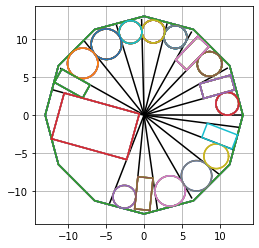

In [155]:
SHELF_DIAMETER = 26
SHELF_HEIGHT = 5

CATALOG = {"Sarah Palette": Rectangle(13.25, 8.75, 0.75),
           "Florence Palatte": Rectangle(10.25, 6.25, 0.75),
           "Imogene Brush Rest": Rectangle(4.25, 2, 0.75),
           "London Painter's Dish": Circle(4, 1.5),
           "Tierney Ray Palette": Rectangle(10.25, 8.75, 0.75),
           "Savanna Tool Holder": Circle(3, 4),
           "Tessa Trinket Dish": Circle(4, 1.5),
           "Paula Bud Vase": Circle(3.25, 3)}
           
s = Shelf(SHELF_DIAMETER, SHELF_HEIGHT)
CIRCLE_DIAMETER = SHELF_DIAMETER*np.cos((15/360)*2*np.pi)
next_theta_begin = 0
product_list = list(CATALOG.keys())
plt.plot([0, SHELF_DIAMETER/2], [0, 0], 'k-')
while next_theta_begin < 2*np.pi and len(product_list) > 0:
    i = random.randint(0, len(product_list)-1)
    next_product = copy.deepcopy(CATALOG[product_list[i]])
    if next_product.height > s.height:
        product_list.pop(i)
        continue

    angular_space_used = 0
    origin = ()
    if type(next_product) is Circle:
        r_circ = next_product.d/2
        r = CIRCLE_DIAMETER/2 - r_circ
        theta = next_theta_begin + np.arcsin(r_circ/(CIRCLE_DIAMETER/2 - r_circ))
        origin = PolarPoint(r, theta)
        angular_space_used = 2*np.arcsin(r_circ/(CIRCLE_DIAMETER/2 - r_circ))
    elif type(next_product) is Rectangle:
        diag = np.hypot(next_product.l, next_product.w)
        if diag > CIRCLE_DIAMETER/2:
            x_tr = np.cos(next_theta_begin)*next_product.l/2 - np.sin(next_theta_begin)*next_product.w
            y_tr = np.sin(next_theta_begin)*next_product.l/2 + np.cos(next_theta_begin)*next_product.w
            origin = to_polar(Point(x_tr, y_tr))
            angular_space_used = np.pi
        else:
            r = CIRCLE_DIAMETER/2
            theta = next_theta_begin + np.arcsin(next_product.w/(CIRCLE_DIAMETER/2))
            origin = PolarPoint(r, theta)
            x_prime = np.sqrt((origin.as_xy.x - (next_product.l*np.cos(next_theta_begin)) + (next_product.w*np.sin(next_theta_begin)))**2 + (origin.as_xy.y - (next_product.l*np.sin(next_theta_begin)) - (next_product.w*np.cos(next_theta_begin)))**2)
            angular_space_used = abs(np.arctan2(next_product.w, x_prime))
    else:
        product_list.pop(i)
        continue
    
    if angular_space_used <= 2*np.pi - next_theta_begin:
        if type(next_product) is Circle:
            next_product.set_position(origin)
        else:
            # Type is rectangle
            next_product.set_position(origin, next_theta_begin)
        s.place_item(next_product)
        next_theta_begin += angular_space_used
        endpoint = PolarPoint(CIRCLE_DIAMETER/2, next_theta_begin).as_xy
        plt.plot([0, endpoint.x], [0, endpoint.y], 'k-')
        plot_polys([s.shape]+s.item_shapes())
    else:
        product_list.pop(i)

## Function Definitions for Running Many Trials

In [147]:
def pack_item(next_product, s: Shelf, largest_circle_radius, next_theta_begin):
    '''
    Attempt to pack the next product into the kiln.

    Parameters:
    next_product (Circle or Rectangle) : The next order in the list
    s (Shelf) : The shelf to pack the order into
    largest_circle_radius (float or number) : The radius of the largest circle
    that will fit in the kiln shelf (computation: R = (D/2)*cos(15 deg))
    next_theta_begin (float or number) : Angle (in radians, [0, 2*pi)) which defines
    the bottom of the object in the coordinate system.

    Output: Tuple of (bool, float):
    bool is True iff the item has been packed in the shelf.
    float is the new value of next_theta_begin.
    '''
    if next_product.height > s.height:
        return (False, next_theta_begin)
    
    angular_space_used = 0
    origin = ()
    if type(next_product) is Circle:
        r_circ = next_product.d/2
        r = largest_circle_radius - r_circ
        theta = next_theta_begin + np.arcsin(r_circ/(largest_circle_radius - r_circ))
        origin = PolarPoint(r, theta)
        angular_space_used = 2*np.arcsin(r_circ/(CIRCLE_DIAMETER/2 - r_circ))
    elif type(next_product) is Rectangle:
        diag = np.hypot(next_product.l, next_product.w)
        if diag > CIRCLE_DIAMETER/2:
            x_tr = np.cos(next_theta_begin)*next_product.l/2 - np.sin(next_theta_begin)*next_product.w
            y_tr = np.sin(next_theta_begin)*next_product.l/2 + np.cos(next_theta_begin)*next_product.w
            origin = to_polar(Point(x_tr, y_tr))
            angular_space_used = np.pi
        else:
            r = CIRCLE_DIAMETER/2
            theta = next_theta_begin + np.arcsin(next_product.w/(CIRCLE_DIAMETER/2))
            origin = PolarPoint(r, theta)
            x_prime = np.sqrt((origin.as_xy.x - (next_product.l*np.cos(next_theta_begin)) + (next_product.w*np.sin(next_theta_begin)))**2 + (origin.as_xy.y - (next_product.l*np.sin(next_theta_begin)) - (next_product.w*np.cos(next_theta_begin)))**2)
            angular_space_used = abs(np.arctan2(next_product.w, x_prime))
    else:
        return (False, next_theta_begin)
    
    if angular_space_used <= 2*np.pi - next_theta_begin:
        if type(next_product) is Circle:
            next_product.set_position(origin)
        else:
            # Type is rectangle
            next_product.set_position(origin, next_theta_begin)
        s.place_item(next_product)
        return (True, next_theta_begin + angular_space_used)
    else:
        return (False, next_theta_begin)

In [148]:
def fill_shelf_with_random_items(s: Shelf, catalog: dict, largest_circle_radius):
    '''
    Given a kiln shelf and a catalog of items, pack the shelf as full as possible
    with a random ordering of items from the catalog.

    Parameters:
    s (Shelf) : A shelf object as defined above
    catalog (dict{str: Rectangle/Circle}) : A catalog of possible products to order
    largest_circle_radius (float or number) : The radius of the largest circle
    that will fit in the kiln shelf (computation: R = (D/2)*cos(15 deg))
    '''
    next_theta_begin = 0
    product_list = list(catalog.keys())
    while next_theta_begin < 2*np.pi and len(product_list) > 0:
        i = random.randint(0, len(product_list)-1)
        next_product = copy.deepcopy(catalog[product_list[i]])
        packed, next_theta_begin = pack_item(next_product, s, largest_circle_radius, next_theta_begin)
        if not packed:
            product_list.pop(i)

## Simulation and Results

49.481711212768246% packing density.
Shelf Height: 2 in.
Average: 43.2155336202836% packing density.
Standard Deviation: 3.612938380859828% packing density.

42.96104536489152% packing density.
Shelf Height: 3 in.
Average: 42.33379021946874% packing density.
Standard Deviation: 3.607530692658893% packing density.

45.111344919880004% packing density.
Shelf Height: 4 in.
Average: 41.75252648819698% packing density.
Standard Deviation: 3.565776548294604% packing density.



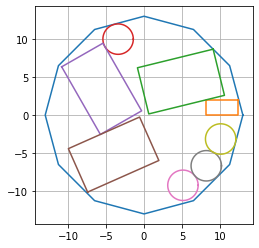

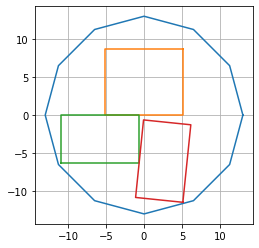

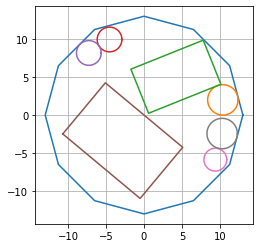

<Figure size 432x288 with 0 Axes>

In [154]:
SHELF_DIAMETER = 26 # in
CIRCLE_RADIUS = (SHELF_DIAMETER/2)*np.cos((15/360)*2*np.pi) # in
MIN_SHELF_HEIGHT = 2 # in
MAX_SHELF_HEIGHT = 4 # in

CATALOG = {"Sarah Palette": Rectangle(13.25, 8.75, 0.75),
           "Florence Palatte": Rectangle(10.25, 6.25, 0.75),
           "Imogene Brush Rest": Rectangle(4.25, 2, 0.75),
           "London Painter's Dish": Circle(4, 1.5),
           "Tierney Ray Palette": Rectangle(10.25, 8.75, 0.75),
           "Savanna Tool Holder": Circle(3, 4),
           "Tessa Trinket Dish": Circle(4, 1.5),
           "Paula Bud Vase": Circle(3.25, 3)}

NUM_TRIALS = 1000

for height in range(MIN_SHELF_HEIGHT, MAX_SHELF_HEIGHT+1):
    packing_factors = []
    for i in range(NUM_TRIALS):
        s = Shelf(SHELF_DIAMETER, height)
        fill_shelf_with_random_items(s, CATALOG, CIRCLE_RADIUS)
        packing_factors.append(s.packing_factor())
        if i == 0:
            plot_polys([s.shape] + s.item_shapes())
            print(str(s.packing_factor()*100) + "% packing density.")
            plt.savefig('shelf_packing_'+str(height)+'_in.png')
            plt.figure()

    average_packing_factor = 100*sum(packing_factors)/NUM_TRIALS
    standard_dev = 100*np.std(packing_factors)

    print("Shelf Height: " + str(height) + " in.")
    print("Average: " + str(average_packing_factor) + "% packing density.")
    print("Standard Deviation: " + str(standard_dev) + "% packing density.")
    print()
